In [1]:
import matplotlib.pyplot as plt
from scipy.signal import argrelmax,argrelmin
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import scipy.signal.spectral as spectral
from math import ceil,floor
import os
import shutil

In [2]:
class Hermite(object):
    '''
    分段Hermite插值.
    '''
    def __init__(self,x,y):
        self.x=x
        self.y=y
        self.__D=[]
        self.derivatives=self.__get_derivatives()
        
    def __derivative_start(self,x0,x1,x2,y0,y1,y2):
        m1=(y1-y0)/(x1-x0)
        m2=(y2-y1)/(x2-x1)
        m3=((x1-x0)+(x2-x1))
        D0=((2*(x1-x0)+(x2-x1))*m1-(x1-x0)*m2)/m3
        if D0*m1>=0:
            D0=0
        elif m2*m1>=0 and abs(D0)>abs(3*m1):
            D0=3*m1
        return D0
    
    def __derivative_middle(self,xj_1,xj,xjp1,yj_1,yj,yjp1):
        D1=(yjp1-yj)/(xjp1-xj)
        D2=(yj-yj_1)/(xj-xj_1)
        if D1*D2<=0:
            Dj=0
        else:
            w1=2*(xj-xj_1)+(xjp1-xj)
            w2=(xj-xj_1)+2*(xjp1-xj)
            Dj=(w1+w2)/((w1/D2)+(w2/D1))
        return Dj
    
    
    def __derivative_end(self,xn_2,xn_1,xn,yn_2,yn_1,yn):
        m1=(yn-yn_1)/(xn-xn_1)
        m2=(yn_1-yn_2)/(xn_1-xn_2)
        m3=(xn-xn_1)+(xn_1-xn_2)
        Dn=((2*(xn-xn_1)+(xn_1-xn_2))*m1-(xn-xn_1)*m2)/m3
        if Dn*m1>=0:
            Dn=0
        elif m2*m1>=0 and abs(Dn)>abs(3*m1):
            Dn=3*m1
        return Dn
    
    def __get_derivatives(self):
        self.__D.append(self.__derivative_start(self.x[0],self.x[1],self.x[2],self.y[0],self.y[1],self.y[2]))
        
        for j in range(1,len(self.x)-1):
            self.__D.append(self.__derivative_middle(self.x[j-1],self.x[j],self.x[j+1],self.y[j-1],self.y[j],self.y[j+1]))
    
        self.__D.append(self.__derivative_end(self.x[-3],self.x[-2],self.x[-1],self.y[-3],self.y[-2],self.y[-1]))
        return self.__D
    
    def __get_singel_hermite(self,xj_1,xj,yj_1,yj,T_singel,mid):
        Dj_1,Dj=self.__D[mid],self.__D[mid+1]
        h1=(1+2*(T_singel-xj_1)/(xj-xj_1))*yj_1*((T_singel-xj)/(xj_1-xj))**2
        h2=(1+2*(T_singel-xj)/(xj_1-xj))*yj*((T_singel-xj_1)/(xj-xj_1))**2
        h3=(T_singel-xj_1)*Dj_1*((T_singel-xj)/(xj_1-xj))**2
        h4=(T_singel-xj)*Dj*((T_singel-xj_1)/(xj-xj_1))**2
        H_singel=h1+h2+h3+h4
        return H_singel

    def __Find(self,x,key):#找到相应的分段函数的索引
        low=0
        high=len(x)-1
        while True:
            mid=int((low+high)/2)
            if x[mid]<= key < x[mid+1]:
                break
            elif key >= x[mid+1]:
                low=mid
            elif key < x[mid]:
                high=mid
        return mid
    
    def get_all_hermite_values(self,T):
        if T[0]<self.x[0] or T[-1]>self.x[-1]:
            raise IndexError('插值超出范围！')
        H=[]
        for i in range(len(T)-1):
            mid=self.__Find(self.x,T[i])
            H.append(self.__get_singel_hermite(self.x[mid],self.x[mid+1],self.y[mid],self.y[mid+1],T[i],mid))
        if T[-1]==self.x[-1]:
            H.append(self.y[-1])
        else:
            mid=self.__Find(self.x,T[-1])
            H.append(self.__get_singel_hermite(self.x[mid],self.x[mid+1],self.y[mid],self.y[mid+1],T[i],mid))
        return np.array(H)

In [3]:
def direct_extension1(xmax,ymax,xmin,ymin,x,y):
    '''
    端点直接延拓方法1，只取前两个极值做平均.
    '''
    xmax.insert(0,x[0]-10**(-10))
    if y[0]>ymax[0]:
        ymax.insert(0,y[0])
    else:
        ymax.insert(0,(ymax[0]+ymax[1])/2)

    xmax.append(x[-1]+10**(-10))
    if y[-1]>ymax[-1]:
        ymax.append(y[-1])
    else:
        ymax.append((ymax[-2]+ymax[-1])/2)

        
        
    xmin.insert(0,x[0]-10**(-10))
    if y[0]<ymin[0]:
        ymin.insert(0,y[0])
    else:
        ymin.insert(0,(ymin[0]+ymin[1])/2)
        
    xmin.append(x[-1]+10**(-10))
    if y[-1]<ymin[-1]:
        ymin.append(y[-1])
    else:
        ymin.append((ymin[-2]+ymin[-1])/2)

    return xmax,ymax,xmin,ymin



def direct_extension2(xmax,ymax,xmin,ymin,x,y):
    '''
    端点直接延拓方法2，取一半的极值做平均.
    '''
    xmax.insert(0,x[0]-10**(-10))
    
    if y[0]>ymax[0]:
        ymax.insert(0,y[0])
    elif len(ymax)%2==0:
        ymax.insert(0,sum(ymax[0:int(len(ymax)/2)])/len(ymax[0:\
                    int(len(ymax)/2)]))
    elif len(ymax)%2!=0:
        ymax.insert(0,sum(ymax[0:int((len(ymax)+1)/2)])/len(ymax[0:\
                    int((len(ymax)+1)/2)]))
        
    xmax.append(x[-1]+10**(-10))
    
    if y[-1]>ymax[-1]:
        ymax.append(y[-1])
    elif len(ymax)%2==0:
        ymax.append((sum(ymax[int(len(ymax)/2):-1])+ymax[-1])/(len(ymax[\
                    int(len(ymax)/2):-1])+1))
    elif len(ymax)%2!=0:
        ymax.append((sum(ymax[int((len(ymax)-1)/2):-1])+ymax[-1])/(len(ymax[\
                    int((len(ymax)-1)/2):-1])+1))
        
    xmin.insert(0,x[0]-10**(-10))
    
    if y[0]<ymin[0]:
        ymin.insert(0,y[0])
    elif len(ymin)%2==0:
        ymin.insert(0,sum(ymin[0:int(len(ymin)/2)])/len(ymin[0:\
                    int(len(ymin)/2)]))
    elif len(ymin)%2!=0:
        ymin.insert(0,sum(ymin[0:int((len(ymin)+1)/2)])/len(ymin[0:\
                    int((len(ymin)+1)/2)]))
        
    xmin.append(x[-1]+10**(-10))
    
    if y[-1]<ymin[-1]:
        ymin.append(y[-1])
    elif len(ymin)%2==0:
        ymin.append((sum(ymin[int(len(ymin)/2):-1])+ymin[-1])/(len(ymin[\
                    int(len(ymin)/2):-1])+1))
    elif len(ymin)%2!=0:
        ymin.append((sum(ymin[int((len(ymin)-1)/2):-1])+ymin[-1])/(len(ymin[\
                    int((len(ymin)-1)/2):-1])+1))
    return xmax,ymax,xmin,ymin

In [4]:
def extremum_coordinates_with_direct_extension(x,y):
    '''
    将极大值，极小值延拓至与数据平齐.
    '''
    ymaxindex,yminindex=argrelmax(y)[0],argrelmin(y)[0]
    ymax,ymin,xmax,xmin=[],[],[],[]
    for i in ymaxindex:
        ymax.append(y[i])
        xmax.append(x[i])
    for i in yminindex:
        ymin.append(y[i])
        xmin.append(x[i])      
    xmax,ymax,xmin,ymin=direct_extension2(xmax,ymax,xmin,ymin,x,y)
    return xmax,ymax,xmin,ymin

In [5]:
def e_index(fup,fdown,e):
    '''
    上下包络相交的改正，找出fup,fdown中非常接近的数据<索引>,e是预先设定的一个小量，用于判断fup,fdown的接近程度.
    '''
    eindex=[]
    for i in range(1,len(fup)-1):#不检查首尾的点，因为检查出来也无法改正
        if fup[i]-fdown[i]<e:
            eindex.append(i)   
    if len(eindex)!=0:
        return eindex,True,len(eindex)
    else:
        return eindex,False,0
    

def split_i_index(eindexi):
    '''
    将e_index函数得到的<索引>变成由每个小的、连续的部分组成的列表 (要分成连续的一部分),必须与split_e_index函数配合使用.
    '''
    split_indexi=[]
    split_indexi.append(eindexi[0])
    for i in range(1,len(eindexi)):
        if eindexi[i]-eindexi[0]==i:
            split_indexi.append(eindexi[i])
    for i in split_indexi:
        eindexi.remove(i)
    return split_indexi,eindexi

def split_e_index(eindex):
    '''
    将e_index函数得到的<索引>变成由每个小的、连续的部分组成的列表 (要分成连续的一部分),必须与split_i_index函数配合使用.
    '''    
    split_indexall=[]
    while len(eindex)!=0:
        split_indexi,eindex=split_i_index(eindex)
        split_indexall.append(split_indexi)
    return split_indexall
#========================================

#
def disjoin(fup,fdown,x,e):
    '''
    上下包络相交的改正.
    '''
    delta_head=fup[0]-fdown[0]#这里单独处理一下首尾两个点，防止相交后无法处理
    delta_tail=fup[-1]-fdown[-1]
    if delta_head<e:
        fup[0]=fup[0]+(e-delta_head)
        fdown[0]=fdown[0]-(e-delta_head)
    if delta_tail<e:
        fup[-1]=fup[-1]+(e-delta_tail)
        fdown[-1]=fdown[-1]-(e-delta_tail)
    eindex=e_index(fup,fdown,e)
    count=0
    eindex_temporary=[]
    while eindex[1]:
        sindex=split_e_index(eindex[0])
        #for fup
        for i in sindex:
            p_up=[]
            p_upindex=[]
            p_up.append(fup[i[0]-1])
            p_up.append(fup[i[-1]+1])
            p_upindex.append(x[i[0]-1])
            p_upindex.append(x[i[-1]+1])
            p_up=np.array(p_up)
            p_upindex=np.array(p_upindex)
            f1=interp1d(p_upindex,p_up,kind='linear')(x[(i[0]-1):(i[-1]+2)])
            fup[(i[0]-1):(i[-1]+2)]=(fup[(i[0]-1):(i[-1]+2)]+f1)/2
            
        #for fdown
        for i in sindex:
            p_down=[]
            p_downindex=[]
            p_down.append(fdown[i[0]-1])
            p_down.append(fdown[i[-1]+1])
            p_downindex.append(x[i[0]-1])
            p_downindex.append(x[i[-1]+1])
            p_down=np.array(p_down)
            p_downindex=np.array(p_downindex)
            f2=interp1d(p_downindex,p_down,kind='linear')(x[(i[0]-1):(i[-1]+2)])
            fdown[(i[0]-1):(i[-1]+2)]=(fdown[(i[0]-1):(i[-1]+2)]+f2)/2
        
        eindex=e_index(fup,fdown,e)
        count+=1
        if count%5==0:
            print('改正相交迭代的次数：',count)
        if count==50:
            eindex=e_index(fup,fdown,e-10**(-4))
        if count==200:
            raise ValueError('无法改正上下包络的相交！')
    return fup,fdown

In [6]:

def ask(t,ui):
    '''
    大循环询问项
    '''
    plt.figure(figsize=(12,4))
    plt.plot(t,ui)
    plt.xlabel('t')
    plt.ylabel('ui')
    plt.show()
    while True:
        f=input('Stop it?(y/n)')
        if f not in ['y','n']:
            print('请按指定格式输入！')
        else:
            break
    if f=='n':
        return True
    else:
        return False

In [7]:
def stop(ui,s):
    '''
    大循环终止条件
    '''
    if abs(max(ui)-min(ui))<0.1*abs(max(s)-min(s)) or ((len(argrelmax(ui)[0])==0 and len(argrelmin(ui)[0])==0)):
        return '符合'
    else:
        return '不符合'

In [8]:
#与数据相关的函数
def getData_txt(filename):
    '''
    打开txt文件,文件结构必须是：两列,第一列是时间，第二列是幅值，两列之间至少空一格.
    '''
    t=[]
    s=[]
    with open(filename) as fp:
        for line in fp.readlines():
            linelst=line.split()
            t.append(float(linelst[0]))
            s.append(float(linelst[1]))
    return np.array(t),np.array(s)

def getData_fits(filename):
    '''
    打开fits文件，仅为打开sac13.fits设计,不同的fits文件需重新编辑此函数.
    '''
    with fits.open(filename) as hud:
        t=hud[1].data.field('TIME')
        t=t-t[0]
        s=hud[1].data.field('RATE')
        s=s.astype('float32')
    return t,s


def extension_data(t,s):
    '''
    扩展数据，将原始数据左边三分之一镜像放在数据左端点之前，将原始数据右边三分之一数据镜像放在数据右端点之后.
    该函数返回的是延拓好的数据.
    '''
    s=list(s)
    N=len(t)
    N1=ceil(N/3)
    N2=floor(2*N/3)
    s_left=s[1:N1]
    s_left.reverse()
    s_right=s[N2:-1]
    s_right.reverse()
    t_left=list(-1*t[1:N1])
    t_left.reverse()
    t_right=list(t[N2:-1]+(N-N2)*(t[1]-t[0]))
    t=list(t)
    S=s_left+s+s_right
    T=t_left+t+t_right
    return np.array(T),np.array(S)

In [9]:
def plot_data_extensioned():
    '''
    画图相关的函数,画经过extension_data函数延拓之后分解的结果的图像.
    '''
    fig=plt.figure(figsize=(16,9))
    nfig=len(PF)+2
    ax1=fig.add_subplot(nfig,1,1)
    ax1.plot(t,s)
    N=len(t)
    N1=ceil(N/3)
    N11=len(s[1:N1])
    N22=len(PF[1])-N11
    for i in range(len(PF)):
        axi=fig.add_subplot(nfig,1,i+2)
        axi.plot(t,PF[i][N11:N22])
    axn=fig.add_subplot(nfig,1,nfig)
    axn.plot(t,remnant[N11:N22][-1])
    plt.tight_layout()

def plot_data_raw(size,fontsize):
    '''
    画图相关的函数,画未经过extension_data函数延拓之后分解的结果.
    '''
    fig=plt.figure(figsize=size)
    nfig=len(PF)+2
    ax1=fig.add_subplot(nfig,1,1)
    ax1.plot(t,s)
    ax1.set_xlabel('t',fontsize=fontsize[0])
    ax1.set_ylabel('Data',fontsize=fontsize[0])
    ax1.tick_params(labelsize=fontsize[1])
    for i in range(len(PF)):
        axi=fig.add_subplot(nfig,1,i+2)
        axi.plot(t,PF[i])
        axi.set_xlabel('t',fontsize=fontsize[0])
        axi.set_ylabel('PF%d'%(i),fontsize=fontsize[0])
        axi.tick_params(labelsize=fontsize[1])
    axn=fig.add_subplot(nfig,1,nfig)
    axn.plot(t,remnant[-1])
    axn.set_xlabel('t',fontsize=fontsize[0])
    axn.set_ylabel('remnant',fontsize=fontsize[0])
    axn.tick_params(labelsize=fontsize[1])
    plt.tight_layout()

In [10]:
def write_data(A,S,PF,remnant,name):
    flag=0
    dirname=name+'_lmdResult'
    if os.path.exists('./output_data/%s'%dirname):
        question=input('文件已经存在,你要覆盖吗?y/n ')
        while question not in ['y','n']:
            print('请按指定格式输入！')
            question=input('文件已经存在,你要覆盖吗?y/n ')
        if question=='y':
            shutil.rmtree('./output_data/%s'%dirname)
        else:
            flag=1
            
    if flag==0:
        os.mkdir('./output_data/%s'%dirname)
        for i in range(len(PF)):
            with open('./output_data/{0}/ASPFR{1}.txt'.format(dirname,i),'w') as file:
                for j in range(len(t)):
                    file.writelines(str('%-7.25f'%A[i][j])+'\t'+str('%-7.17f'%S[i][j])+'\t'+\
                                    str('%-7.17f'%PF[i][j])+'\t'+str('%-7.17f'%remnant[i][j])+'\n')
                    
    print('文件已写入./output_data/sac13.txt')

In [11]:
def ma(t,s):
    '''
    局域均值、幅值函数.  
    '''
    xmax,ymax,xmin,ymin=extremum_coordinates_with_direct_extension(t,s)#极值坐标  
    fup=Hermite(xmax,ymax).get_all_hermite_values(t)
    fdown=Hermite(xmin,ymin).get_all_hermite_values(t)
    print('mean(fup-fdown):',np.mean(fup-fdown)/4)
    fup,fdown=disjoin(fup,fdown,t,e=np.mean(fup-fdown)/4)
    m=(fup+fdown)/2
    a=abs((fup-fdown)/2)
    return m,a

In [12]:
def lmd_main(t,s,simple='no',len_pf=0):
    '''
    lmd主函数.如果只做lmd,则默认simpl，len_pf即可，这两个参数是给elmd用的。
    '''
    #t,s=extension_data(t,s)#将数据左侧三分之一添加到左侧，右侧三分之一添加到右侧.
    ui=s
    if simple=='no':
        N=len(t)
        A,S,PF,remnant,i=[],[],[],[],0
        while ask(t,ui):
            si=ui
            ai=np.ones(len(t))
            while True:
                m,a=ma(t,si)
                hi=si-m
                ai=ai*a
                si=hi/a
                stop_this=sum(abs(a-np.ones(N))/N)
                print(stop_this)
                if stop_this<30:
                    break    
            
            for j in range(len(si)):#将纯调频函数的上下界设为1
                if si[j]>1:
                    si[j]=1
                elif si[j]<-1:
                    si[j]=-1
            i+=1
            pfi=ai*si
            ui=ui-pfi
            A.append(ai)
            S.append(si)
            PF.append(pfi)
            remnant.append(ui)
            print('已产生{}个PF,残余项{}终止条件！'.format(i,stop(ui,s)))
        A=np.array(A)
        S=np.array(S)
        PF=np.array(PF)
        remnant=np.array(remnant)
    
    else:
        len_pf=len_pf
        N=len(t)
        A=np.zeros([len_pf,N])
        S=np.zeros([len_pf,N])
        PF=np.zeros([len_pf,N])
        remnant=np.zeros([len_pf,N])
        for i in range(len_pf):
            si=ui
            ai=np.ones(len(t))
            while True:
                m,a=ma(t,si)
                hi=si-m
                ai=ai*a
                si=hi/a
                print('h:',max(hi),min(hi),np.mean(hi))
                print('a:',max(a),min(a),np.mean(a))
                print('si:',max(si),min(si),np.mean(si))
                stop_this=sum(abs(a-np.ones(N)))
                print('stop_little:',stop_this)
                if stop_this<30:
                    break  
                
            plt.plot(si)
            for j in range(len(si)):#将纯调频函数的上下界设为1
                if si[j]>1:
                    si[j]=1
                elif si[j]<-1:
                    si[j]=-1
            pfi=ai*si
            ui=ui-pfi
            A[i]=ai
            S[i]=si
            PF[i]=pfi
            remnant[i]=ui
            print('已产生{}个PF.'.format(i+1))
    print('\n')
    return A,S,PF,remnant

In [13]:
def elmd_main(t,s,sigma_gauss,n_gauss):
    '''
    elmd主函数
    '''
    N=len(t)
    sigma_source=np.sqrt(s.var())
    print('第1个lmd:')
    alpha=sigma_gauss/sigma_source
    np.random.seed(0)
    gaus_1=alpha*np.random.normal(0,sigma_gauss,N)
    source_1=s+gaus_1
    lmd_1=lmd_main(t,source_1)
    len_pf=len(lmd_1[2])
    A=np.zeros([len_pf,N])
    S=np.zeros([len_pf,N])
    PF=np.zeros([len_pf,N])
    remnant=np.zeros([len_pf,N])
    A=A+lmd_1[0]
    S=S+lmd_1[1]
    PF=PF+lmd_1[2]
    remnant=remnant+lmd_1[3]
    n_gauss=n_gauss
    if n_gauss>1:
        for i in range(1,n_gauss):
            print('第%d个lmd:'%(i+1))
            np.random.seed(i)
            gaus_i=alpha*np.random.normal(0,sigma_gauss,N)
            source_i=s+gaus_i
            lmd_i=lmd_main(t,source_i,simple='yes',len_pf=len_pf)
            A=A+lmd_i[0]
            S=S+lmd_i[1]
            PF=PF+lmd_i[2]
            remnant=remnant+lmd_i[3]

        A=A/n_gauss
        S=S/n_gauss
        PF=PF/n_gauss
        remnant=remnant/n_gauss
        
    return A,S,PF,remnant

mean(fup-fdown): 766.0683010047188
改正相交迭代的次数： 5
h: 11217.925925925923 -8279.674897332035 -1.8090588153015303
a: 11169.457390397056 383.0387373430749 1538.994428980733
si: 7.5554665451540535 -9.494365339412731 -0.014774691159643825
stop_little: 456649001.897532
mean(fup-fdown): 0.45869164725973566
改正相交迭代的次数： 5
h: 4.329525432002456 -5.046234567748307 -0.006946524032166103
a: 5.046234567748307 0.22934882034601115 0.9216433034590124
si: 3.673921652531859 -2.842225569445362 -0.007350725092456023
stop_little: 36838.9743784968
mean(fup-fdown): 0.48158138715098653
改正相交迭代的次数： 5
h: 2.3429151225826508 -2.090930146620539 -0.005681439017321398
a: 2.3429151225826508 0.24079446036665192 0.9644243910468049
si: 2.2360460141127216 -2.3011054591121267 -0.006709191580287868
stop_little: 11640.2657508783
mean(fup-fdown): 0.49499110761876963
h: 1.6180230070563608 -1.6537159566770514 -0.005816318432813466
a: 1.6537159566770514 0.24767608166272173 0.9903958096714147
si: 2.7254524366201838 -1.643458490945827 -

mean(fup-fdown): 0.4876802527557926
改正相交迭代的次数： 5
改正相交迭代的次数： 10
改正相交迭代的次数： 15
改正相交迭代的次数： 20
h: 2.914718586539144 -3.362169465952919 -0.03470552081281589
a: 3.362169465952919 0.2438401265160713 0.9769173895593614
si: 2.8732846144188695 -3.0767847451369597 -0.03514719526113457
stop_little: 8459.04428649506
mean(fup-fdown): 0.49087237421461366
改正相交迭代的次数： 5
改正相交迭代的次数： 10
改正相交迭代的次数： 15
改正相交迭代的次数： 20
改正相交迭代的次数： 25
h: 1.9346484111998832 -2.208427114963428 -0.035155968141328285
a: 2.208427114963428 0.24543618710748039 0.9828341931608442
si: 3.228487548799767 -3.77274750623066 -0.03529774890978229
stop_little: 5881.9839063661075
mean(fup-fdown): 0.49410177855292403
改正相交迭代的次数： 5
改正相交迭代的次数： 10
改正相交迭代的次数： 15
h: 1.9003656182498072 -2.1963069678539844 -0.03377233284745566
a: 2.2109154990984496 0.24705088947271475 0.9889813136228333
si: 3.3146341792875327 -3.625502629780038 -0.03406881952300414
stop_little: 4075.995715998429
mean(fup-fdown): 0.49561194865329594
改正相交迭代的次数： 5
改正相交迭代的次数： 10
改正相交迭代的次数： 15

改正相交迭代的次数： 30
改正相交迭代的次数： 35
改正相交迭代的次数： 40
改正相交迭代的次数： 45
改正相交迭代的次数： 50
h: 2.8284320691427833 -2.6487472822003615 -0.01201445746829728
a: 2.834037928799453 0.24612370497551714 0.9856157435352816
si: 3.932085726050089 -3.9296904046194108 -0.011377545845026777
stop_little: 5758.962916996936
mean(fup-fdown): 0.4926702947185025
改正相交迭代的次数： 5
改正相交迭代的次数： 10
改正相交迭代的次数： 15
改正相交迭代的次数： 20
改正相交迭代的次数： 25
改正相交迭代的次数： 30
改正相交迭代的次数： 35
h: 2.2222319761778233 -2.3225556421476306 -0.012555291672871949
a: 2.3225806347001847 0.246335147359252 0.9863718513813342
si: 3.3014458583485826 -3.0313170648838526 -0.01196557556139633
stop_little: 4848.999283476108
mean(fup-fdown): 0.4940189835913893
改正相交迭代的次数： 5
改正相交迭代的次数： 10
改正相交迭代的次数： 15
改正相交迭代的次数： 20
改正相交迭代的次数： 25
改正相交迭代的次数： 30
改正相交迭代的次数： 35
改正相交迭代的次数： 40
h: 2.581092602117006 -1.7561199565854413 -0.012741127294850534
a: 2.581092602117006 0.24700949179569465 0.9888178276955409
si: 3.787538181831847 -3.9670394035826253 -0.012476484995312852
stop_little: 3883.490336839

si: 1.059604074661864 -1.051119153559678 -0.012633574899042608
stop_little: 71.06027265685626
mean(fup-fdown): 0.4999859556645054
h: 1.0376412097440673 -1.048322789139768 -0.012626379414065938
a: 1.049776216995269 0.5019824964781383 0.9999719113290108
si: 1.0081904588844972 -1.0 -0.01262338166492493
stop_little: 9.952075038396615
已产生4个PF.


done
Wall time: 13min 12s


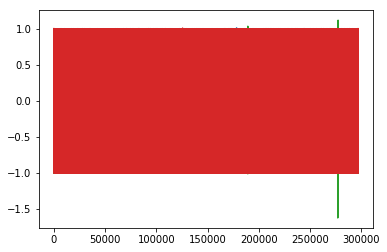

In [14]:
%%time
t,s=getData_fits('sac13.fits')

for i in range(2,len(s)-3):
    if s[i]==s[i-1] and s[i+1]==s[i] and s[i+2]==s[i+1]:
        if s[i-2]>s[i-1] and s[i+3]>s[i+2]:
            s[i]=s[i]-1
            s[i+1]=s[i+1]-2
        elif s[i-2]<s[i-1] and s[i+3]<s[i+2]:
            s[i]=s[i]+1
            s[i+1]=s[i+1]+2

for i in range(2,len(s)-2):
    if s[i]==s[i-1] and s[i+1]==s[i]:
        if s[i-2]>s[i-1] and s[i+2]>s[i+1]:
            s[i]=s[i]-1
        elif s[i-2]<s[i-1] and s[i+2]<s[i+1]:
            s[i]=s[i]+1

for i in range(2,len(s)):
    if s[i]==s[i-1]:
        if s[i-2]<s[i-1] and s[i+1]<s[i]:
            s[i]=s[i]+1
        elif s[i-2]>s[i-1] and s[i+1]>s[i]:
            s[i]=s[i]-1  

#A,S,PF,remnant = elmd_main(t,s,sigma_gauss=0.05,n_gauss=1)
A,S,PF,remnant = lmd_main(t,s,simple='yes',len_pf=4)
#from numpy import pi,sin
#t=np.arange(0,8*pi,0.0005)
#s=5*sin(2*pi*100*t)+3*sin(2*pi*60*t)+sin(2*pi*15*t)
#A,S,PF,remnant = lmd_main(t,s,simple='yes',len_pf=3)
print('done')

Wall time: 276 ms


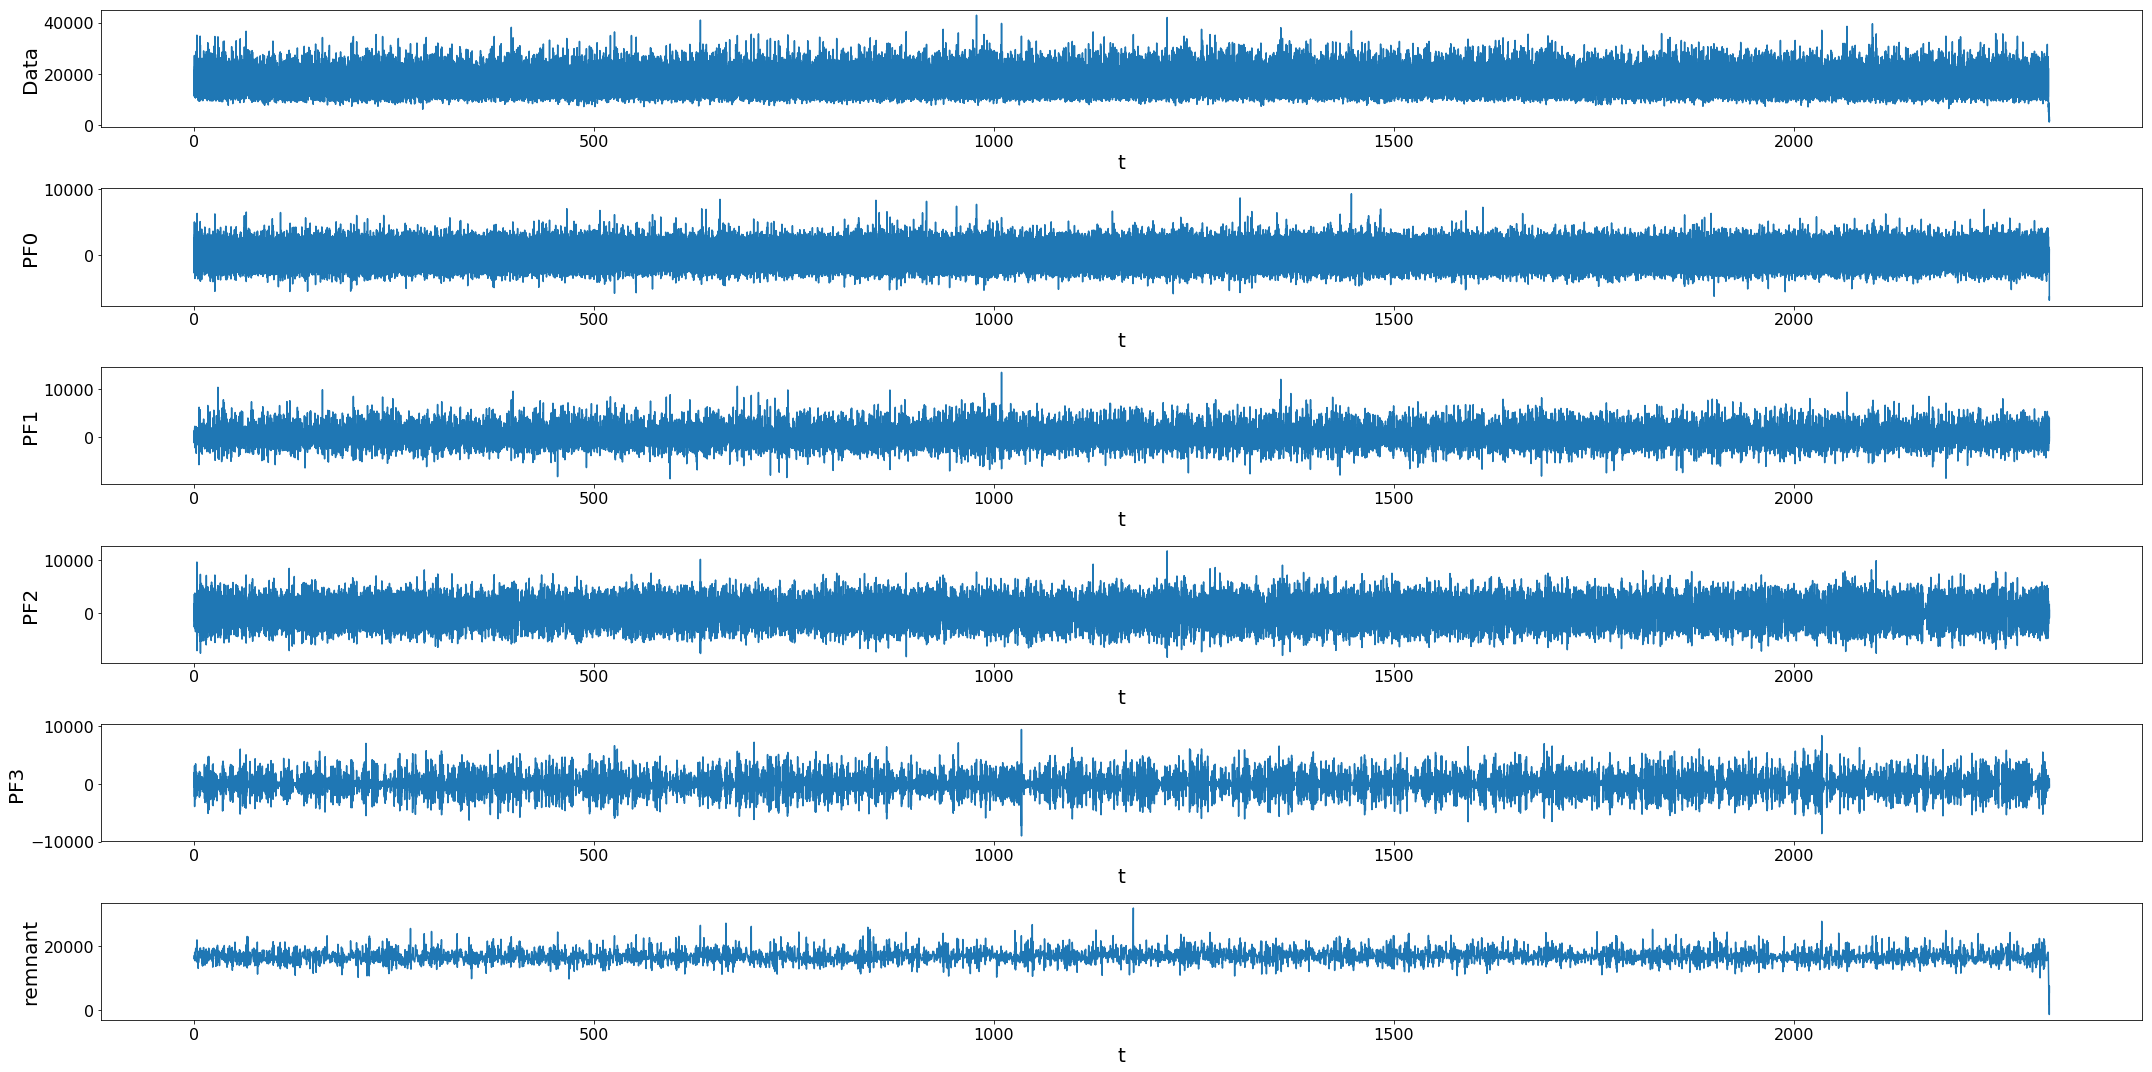

In [15]:
%%time
plot_data_raw(size=(30,15),fontsize=(20,16))

wait...
welch done.
wait...
plot done
Wall time: 497 ms


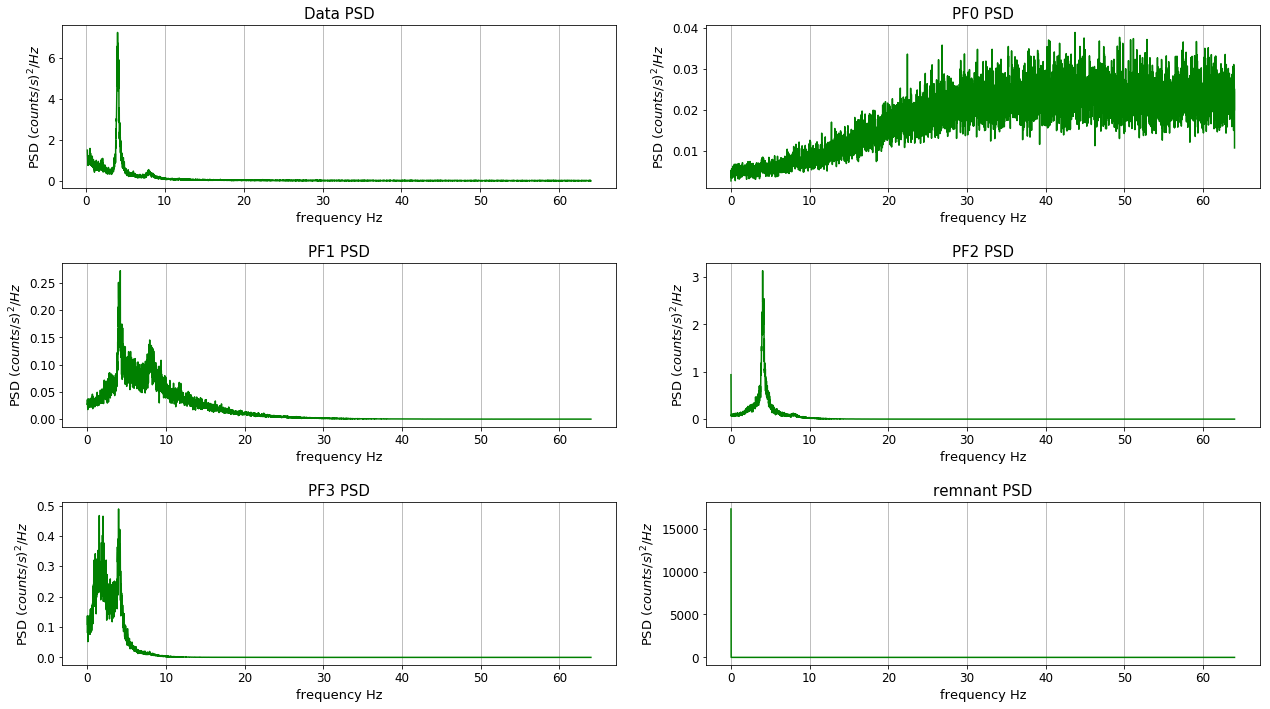

In [16]:
%%time
print('wait...')
fs=1/(t[1]-t[0])
p=[]
N=len(t)
fftsize=2**14
f,p1=spectral.welch(s,nperseg=fftsize,noverlap=None,fs=fs,detrend=None,\
                         window='hann',nfft=None,return_onesided=True,scaling='spectrum')

p.append(p1)
for i in range(len(PF)):
    x_psd=PF[i]
    f,pi=spectral.welch(x_psd,nperseg=fftsize,noverlap=None,fs=fs,detrend=None,\
                         window='hann',nfft=None,return_onesided=True,scaling='spectrum')#welch法
    p.append(pi)
    
f,pn=spectral.welch(remnant,nperseg=fftsize,noverlap=None,fs=fs,detrend=None,\
                         window='hann',nfft=None,return_onesided=True,scaling='spectrum')

p.append(pn)
print('welch done.')

#画图
print('wait...')
fig=plt.figure(figsize=(18,13))
ax=fig.add_subplot(4,2,1)
ax.plot(f[25:],p[0][25:]/fftsize,color='green',markersize=1)
ax.set_title('Data PSD',fontsize=15)
ax.set_ylabel('PSD'+' $(counts/s)^2/Hz$',fontsize=13)
ax.set_xlabel('frequency Hz',fontsize=13)
ax.tick_params(labelsize=12)
#ax.axvline(4,linestyle='--',color='red')
ax.grid(b=True,which='both',axis='x')

for i in range(1,len(PF)+1):
    ax=fig.add_subplot(4,2,i+1)
    ax.plot(f,p[i]/fftsize,color='green',markersize=1)
    ax.set_title('PF%d PSD'%(i-1),fontsize=15)
    ax.set_ylabel('PSD'+' $(counts/s)^2/Hz$',fontsize=13)
    ax.set_xlabel('frequency Hz',fontsize=13)
    ax.tick_params(labelsize=12)
    #ax.axvline(4,linestyle='--',color='red')
    ax.grid(b=True,which='both',axis='x')
    
ax=fig.add_subplot(4,2,len(PF)+2)
ax.plot(f,p[-1][-1]/fftsize,color='green',markersize=1)
ax.set_title('remnant PSD',fontsize=15)
ax.set_ylabel('PSD'+' $(counts/s)^2/Hz$',fontsize=13)
ax.set_xlabel('frequency Hz',fontsize=13)
ax.tick_params(labelsize=12)
#ax.axvline(4,linestyle='--',color='red')
ax.grid(b=True,which='both',axis='x')

#plt.axis('equal')
plt.tight_layout(2)
print('plot done')

In [17]:
#消除小频率比模态混叠(幅值直接修正法)
size1=384
size2=641
f_data=f[size1:size2]
p_data=p[0][size1:size2]
p_PF2=p[3][size1:size2]
A_trapz=np.trapz(p_data,x=f_data)
B_trapz=np.trapz(p_PF2,x=f_data)
print(min(f[size1:size2]),max(f[size1:size2]),A_trapz,B_trapz,A_trapz/B_trapz)
PF2=(A_trapz/B_trapz)*PF[2]
PF2=PF2-np.mean(PF2)
print('PF[2]:',max(PF[2]))
print('PF2:',max(PF2))
print(np.mean(PF2))

3.0 5.0 54890.592025756836 26312.304104558076 2.086118790951802
PF[2]: 11815.885880667236
PF2: 24903.05860610561
6.939939094198774e-14


wait...
done
Wall time: 32 ms


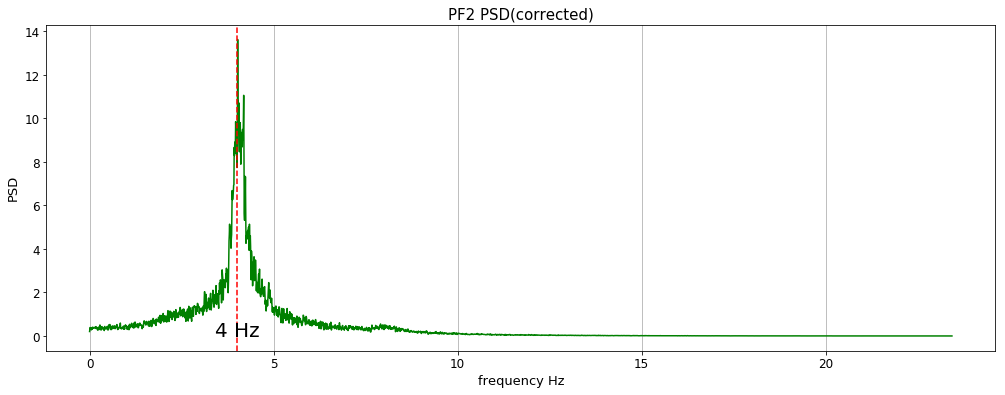

In [18]:
%%time
print('wait...')
fs=1/(t[1]-t[0])
N=len(t)
fftsize=2**14
F,P=spectral.welch(PF2,nperseg=fftsize,noverlap=None,fs=fs,detrend=None,\
                         window='hann',nfft=None,return_onesided=True,scaling='spectrum')

fig=plt.figure(figsize=(17,6))
ax=fig.add_subplot(111)
ax.plot(F[:3000],P[:3000]/fftsize,color='green',markersize=1)
ax.set_title('PF2 PSD(corrected)',fontsize=15)
ax.set_ylabel('PSD',fontsize=13)
ax.set_xlabel('frequency Hz',fontsize=13)
ax.tick_params(labelsize=12)
ax.axvline(4,linestyle='--',color='red')
ax.grid(b=True,which='both',axis='x')

plt.text(x=3.4,y=0,s='4 Hz',fontsize=20)
print('done')

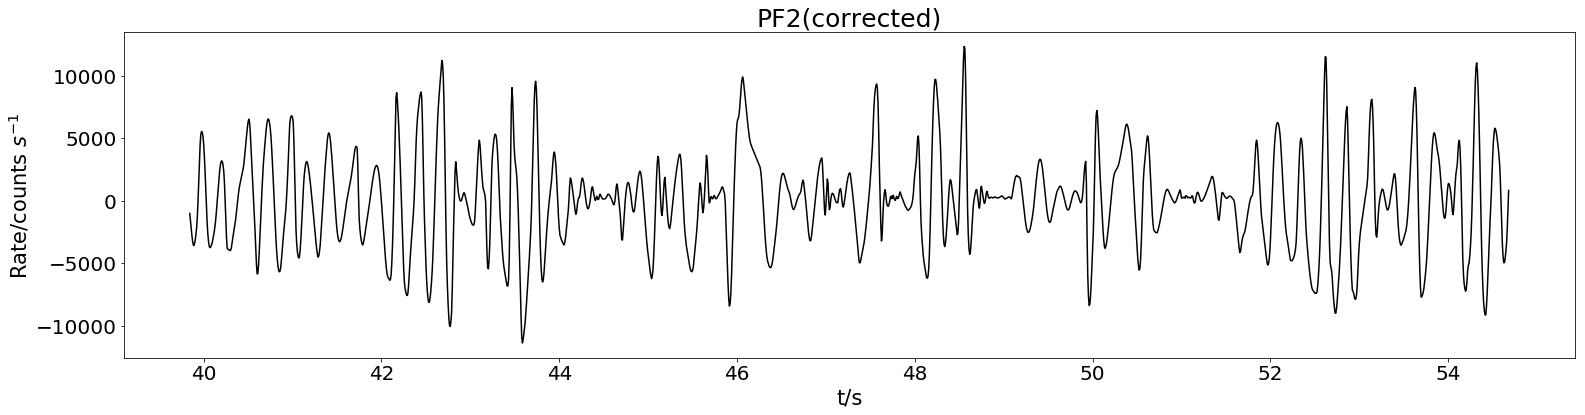

In [19]:
plt.figure(figsize=(26,6))
plt.plot(t[5100:7000],PF2[5100:7000],color='black')
plt.title('PF2(corrected)',fontsize=25)
plt.xlabel('t/s',fontsize=21)
plt.ylabel('Rate/counts $s^{-1}$',fontsize=21)
plt.tick_params(labelsize=20)

In [20]:
write_data(A,S,PF,remnant,name='sac13')

文件已写入./output_data/sac13.txt
